In [1]:
DATA_FPATH = '/nfs_home/craigher/scratch/riboclette/results/interpretability/241001_RDHPLG_int.h5'
FA_FPATH = '/net/lts2gdk0/mnt/scratch/lts2/nallapar/rb-prof/data/Jan_2024/Lina/reference/ensembl.cds.fa'
GC_FPATH = '../data/genetic_code.csv'

In [2]:
import sklearn as skl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
from tqdm.auto import trange, tqdm
from Bio import SeqIO
import re
import seaborn as sns

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

from tqdm.auto import trange

import PyComplexHeatmap as pch

In [3]:
df_trans_to_seq = []
with open(FA_FPATH, mode="r") as handle:
    for record in SeqIO.parse(handle, "fasta"):
        df_trans_to_seq.append([record.id, str(record.seq), record.description.split("gene_symbol:")[1].split()[0]])

df_trans_to_seq = pd.DataFrame(df_trans_to_seq, columns=["transcript", "sequence", "symbol"])
df_trans_to_seq.head()

,transcript,sequence,symbol
0,ENSMUST00000196221.1,ATGGCATAT,Trdd1
1,ENSMUST00000177564.1,ATCGGAGGGATACGAG,Trdd2
2,ENSMUST00000178537.1,GGGACAGGGGGC,Trbd1
3,ENSMUST00000178862.1,GGGACTGGGGGGGC,Trbd2
4,ENSMUST00000179520.1,CTAACTGGGAC,Ighd4-1


In [40]:
RADIUS = 20

In [5]:
RADIUS = 20
windows_attr = []
windows_counts = []
windows_seq = []
with h5py.File(DATA_FPATH, 'r') as f:
    transcripts = f['transcript'][:].astype('U') 
    conditions = f['condition'][:].astype('U') 
    ctrl_mask = np.nonzero(conditions == 'CTRL')[0]
    for transc_idx in tqdm(ctrl_mask):
        y_true = f['y_true_ctrl'][transc_idx]
        trasc_attr = f['lig_ctrl'][transc_idx]
        transcript = transcripts[transc_idx]

        sequence = df_trans_to_seq.query('transcript == @transcript').sequence.values[0]
        n_codons = int(np.sqrt(trasc_attr.shape[0]))
        trasc_attr = trasc_attr.reshape(n_codons, n_codons)

        topk_peaks = np.argsort(y_true)
        topk_peaks = topk_peaks[(topk_peaks >= radius) & (topk_peaks < n_codons - radius - 1)]
        topk_peaks = topk_peaks[-10:]
        #windows.append(np.array([trasc_attr[i,i - radius :i + radius + 1] for i in range(radius, n_codons - radius)]))

        # Generate list of attribution windows
        windows_attr.append(np.array([trasc_attr[i,i - radius :i + radius + 1] for i in topk_peaks]))

        # Generate list of counts windows
        windows_counts.append(np.array([y_true[i - radius :i + radius + 1] for i in topk_peaks]))

        # Generate list of codon windows
        windows_seq.append(np.array([sequence[i*3 - (radius)*3 :i*3 + (radius + 1)*3] for i in topk_peaks]))

# Normalize counts
windows_counts = np.concatenate(windows_counts)
windows_counts = windows_counts / np.nansum(windows_counts, 1)[:,None]

# Normalize sequence
windows_attr = np.abs(np.concatenate(windows_attr))
windows_attr = windows_attr / np.sum(windows_attr, 1)[:,None]

windows_seq = np.concatenate(windows_seq)

  0%|          | 0/980 [00:00<?, ?it/s]

In [189]:
ATTR_PEAK_THRESHOLD = .15

In [190]:
# Extract peaks positions
peaks_data = [tuple(np.where(wa > ATTR_PEAK_THRESHOLD)[0]) for wa in windows_attr]

# Create a cluster_id for each set of peaks
peaks_to_cluster_id = {p: idx for idx, p in enumerate(set(peaks_data))}

# Assign cluster_id to each attribution window
clusters = np.array([peaks_to_cluster_id[p] for p in peaks_data])
print("N clusters = ", len(peaks_to_cluster_id))

N clusters =  159


In [ ]:
# for peaks, cluster in peaks_to_cluster_id.items():
#     plt.figure(figsize=(5,5))
#     cluster_attr = windows_attr[clusters == cluster].mean(0)
#     plt.plot(cluster_attr)
#     for p in peaks:
#         plt.plot(p, cluster_attr[p], "x")

In [191]:
from collections import defaultdict
cluster_codons = defaultdict(list)
for peaks, cluster_id in tqdm(peaks_to_cluster_id.items()):
    if len(peaks) == 0:
        continue
    for p in peaks:
        cluster_codons[cluster_id].append((
            np.sum(clusters == cluster_id),  # Count elements of given cluster
            p-RADIUS, # Make peak location relative to A-site
            [seq[p*3:3*(p+1)] for seq in windows_seq[clusters == cluster_id]] # Find codons appearing at the peak position for a given cluster
        ))

  0%|          | 0/159 [00:00<?, ?it/s]

In [42]:
genetic_code = pd.read_csv(GC_FPATH, index_col=0).set_index('Codon')
genetic_code.head()

,AminoAcid
Codon,
AAA,Lys
AAC,Asn
AAG,Lys
AAT,Asn
ACA,Thr


In [192]:
nunique = []
for cluster_id, v in cluster_codons.items():
    for n_seq, idx, pos in v:
        codons, codon_counts = np.unique(pos, return_counts=True) # Find unique codons and relative counts occurring at a given position
        codon_counts = codon_counts / np.sum(codon_counts) # Normalize the counts
        nunique.append(
            pd.DataFrame(np.stack([codons, codon_counts]).T, columns=['codon', 'freq']).set_index('codon').reindex(genetic_code.index, fill_value=0).reset_index().assign(position=idx, cluster=cluster_id, n_samples=n_seq))


In [196]:
CLUSTER_MIN_SIZE = 50

In [197]:
data = pd.concat(nunique).assign(peak_id=lambda df: df.cluster.astype(str) + "_" + df.position.astype(str))#.set_index('peak_id')#.pivot(columns='Codon', values='freq').astype(float).fillna(0.)
data = data.astype(dict(freq='float', Codon='str', peak_id='str'))
data = data.query(f"n_samples > {CLUSTER_MIN_SIZE}")

In [198]:
data.cluster.nunique()

22

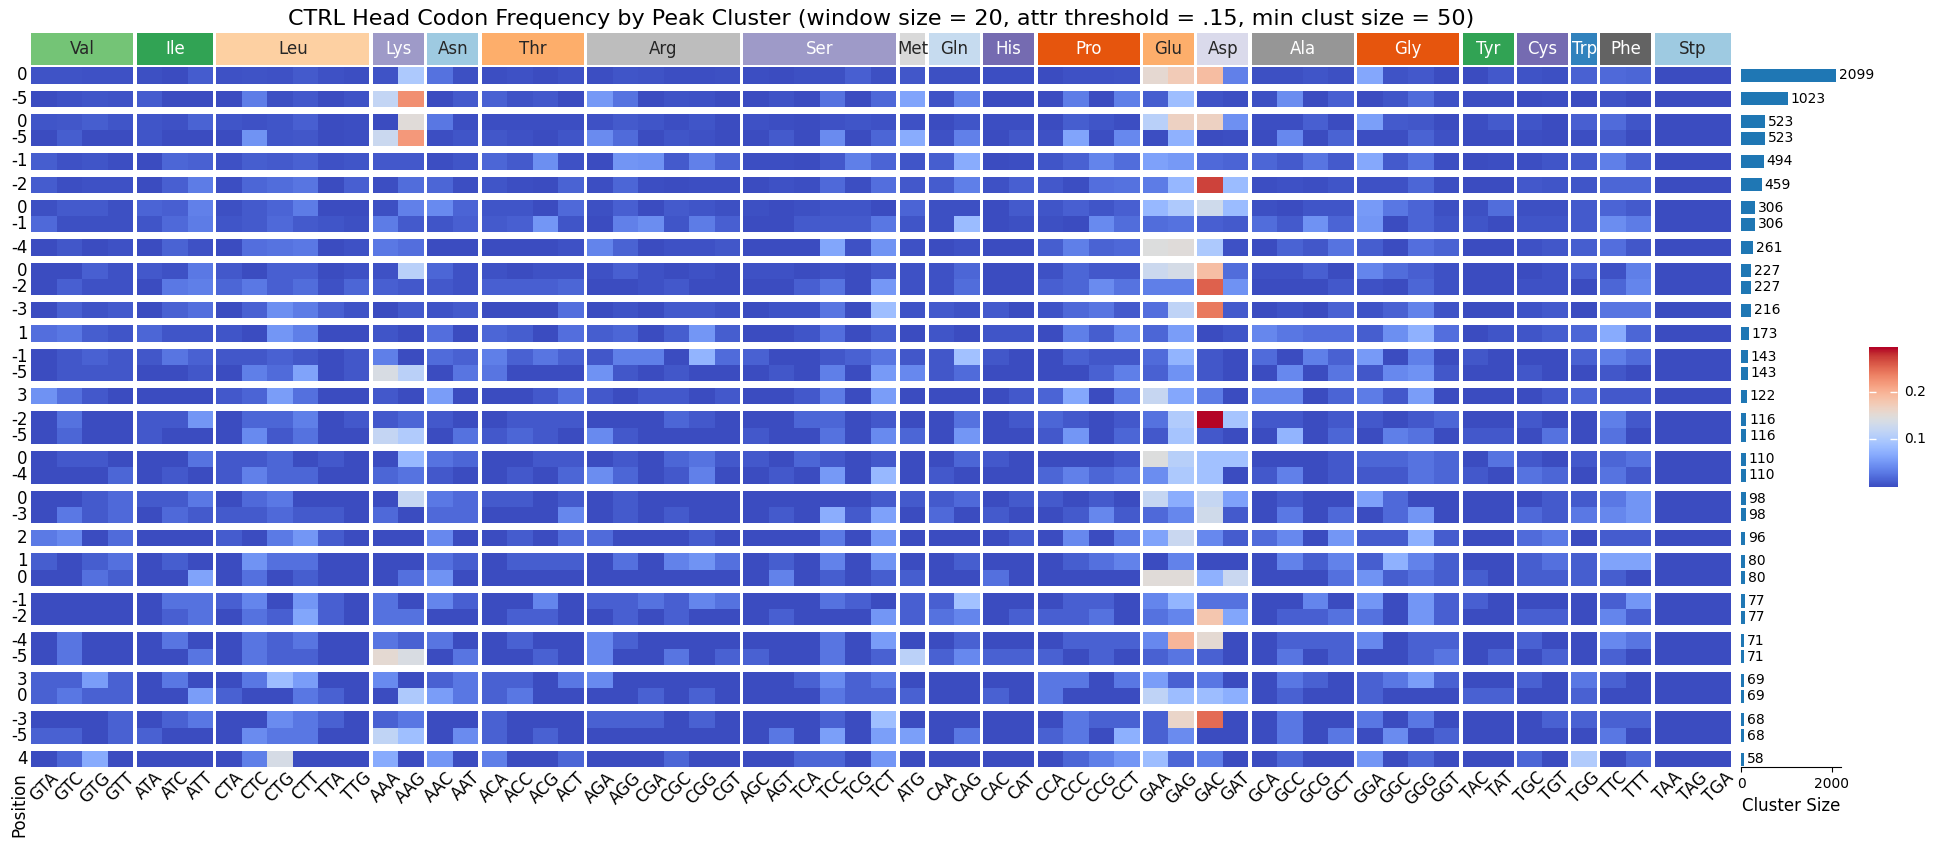

In [208]:
import marsilea as ma

AA = ['Val', 'Ile', 'Leu', 'Lys', 'Asn', 'Thr', 'Arg', 'Ser', 'Met', 'Gln', 'His', 'Pro', 'Glu', 'Asp', 'Ala', 'Gly', 'Tyr', 'Cys', 'Trp', 'Phe', 'Stp']
DEPR_NAMES = {'ILE':'ILE (I)', 'LEU':'LEU (L)', 'VAL':'VAL (V)', 'LEU_ILE':'(L, I)', 'LEU_ILE_VAL':'(L,I,V)'}

cmap = plt.get_cmap('tab20c')
colors = np.array(cmap.colors).repeat(2,0)
np.random.seed(42)
np.random.shuffle(colors)

heatmap_data = data.sort_values(['n_samples', 'cluster', 'position'], ascending=False).pivot_table(index=['peak_id'],columns='Codon', values='freq', sort=False)
row_data = data.groupby(['position', 'cluster']).agg(dict(peak_id='first', n_samples='first')).sort_values(['n_samples', 'position'], ascending=False).reset_index()
h = ma.Heatmap(
    heatmap_data, 
    width=17,
    height=7)
h.group_cols(genetic_code.AminoAcid, spacing=0.002, order=AA)
h.add_top(
        ma.plotter.Chunk(
            AA,
            colors[:len(AA)],
            padding=10,
            fontsize=12
        ),
        pad=0.025
    )
h.add_bottom(ma.plotter.Labels(heatmap_data.columns, rotation=45,fontsize=12), name='Codon')
h.add_left(
        ma.plotter.Labels(
            row_data.position,
            #fill_colors=colors[:len(row_data)],
            #padding=10,
            fontsize=12,
            label="Position",
            label_props=dict(fontsize=12)
        ),
        pad=0.025
    )
h.group_rows(row_data.cluster.values, spacing=0.01, order=row_data.cluster.unique())
h.add_right(
        ma.plotter.Numbers(
            row_data.n_samples.values,
            label="Cluster Size",
            label_props=dict(fontsize=12)
            #fill_colors=colors[:len(row_data)],
            #padding=10,
            #label_props=dict(rotation=90)
        ),
        pad=0.1
    )
h.add_legends()
h.add_title("CTRL Head Codon Frequency by Peak Cluster (window size = 20, attr threshold = .15, min clust size = 50)", fontsize=16)
h.render()
plt.savefig('../results/plots/window_ctrl_head.pdf', dpi=300, bbox_inches='tight')

In [179]:
row_data.n_samples.va

0     2173
1      763
2      373
3      348
4      150
5      147
6      120
7      120
8      102
9       92
10      74
11      59
12      59
13      45
14      45
15      32
16      23
17      23
Name: n_samples, dtype: int64

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 7.5 mm


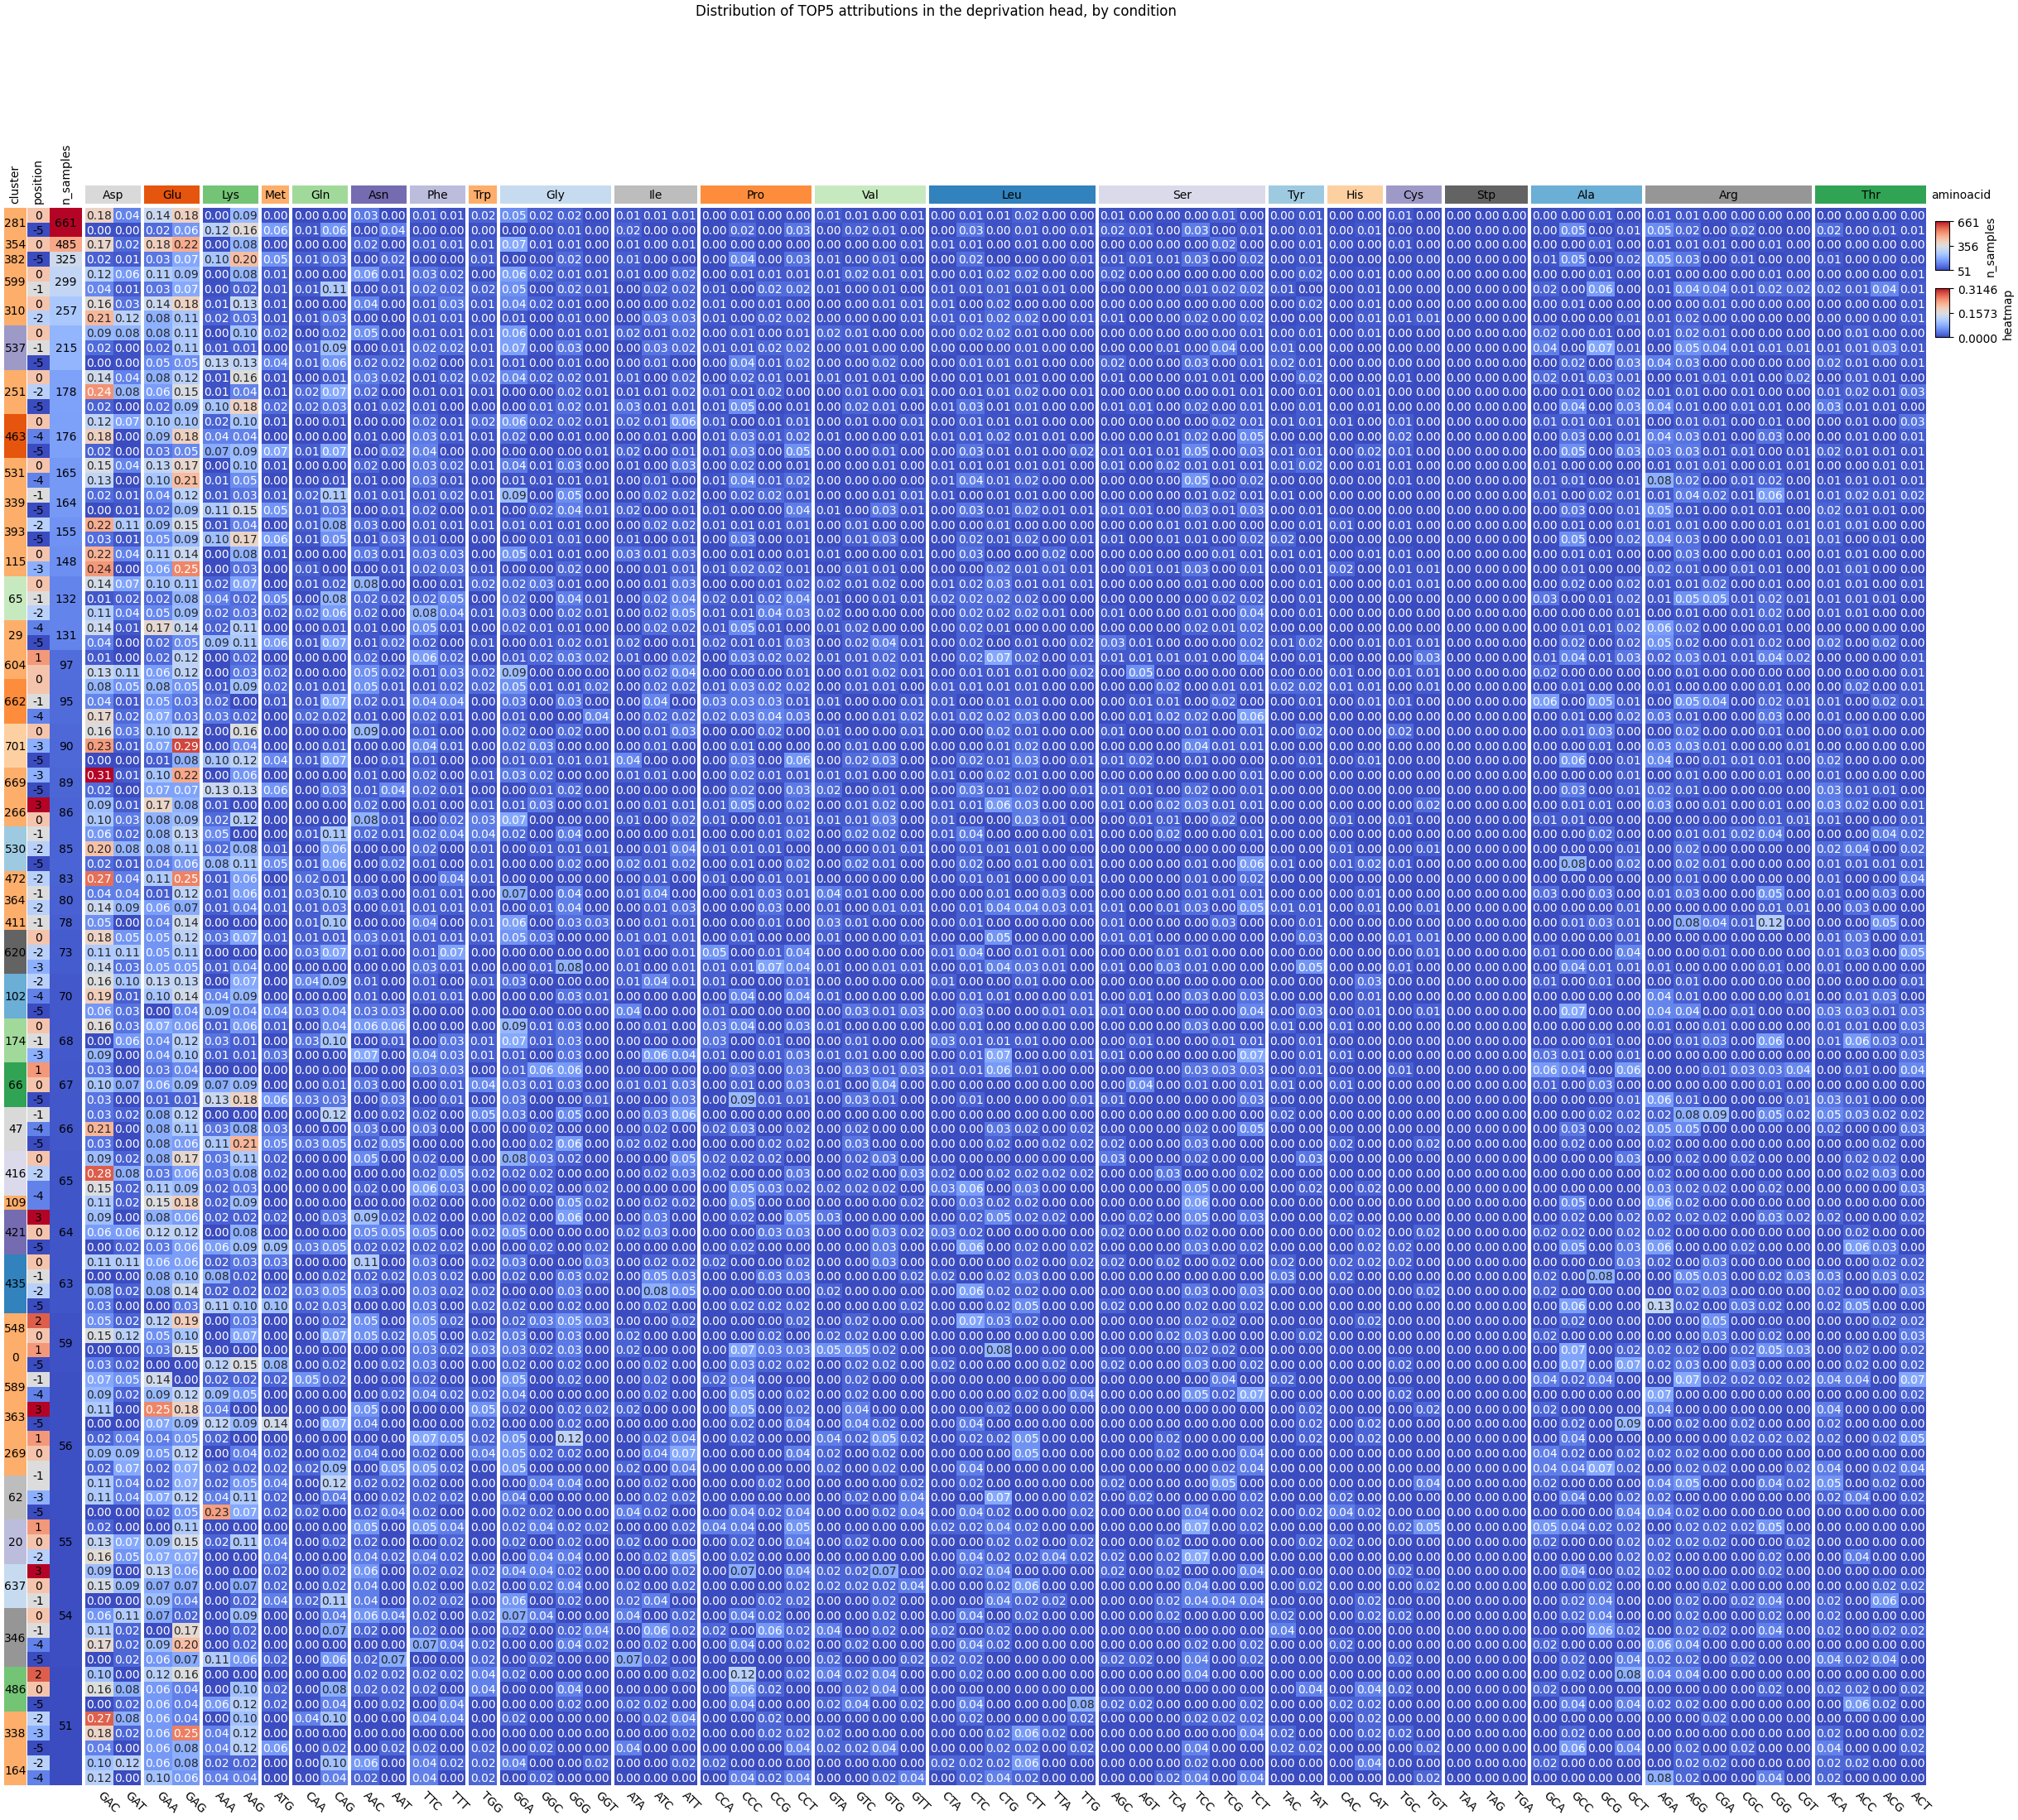

In [28]:
plt.figure(figsize=(30, data.cluster.nunique() // 2))

cmap = plt.get_cmap('tab20c')
colors = np.array(cmap.colors)
np.random.seed(42)
np.random.shuffle(colors)
randomized_cmap = plt.matplotlib.colors.ListedColormap(colors)

col_ha = pch.HeatmapAnnotation(aminoacid=pch.anno_simple(genetic_code, add_text=True,legend=False,text_kws={'fontsize':10, 'color':'black'},cmap=randomized_cmap, height=5),axis=1)
row_ha = pch.HeatmapAnnotation(
    cluster=pch.anno_simple(data.groupby(['peak_id'])[['cluster']].first(), add_text=True, legend=False,text_kws={'fontsize':10, 'color':'black','rotation':0}, height=7,cmap=randomized_cmap),
    position=pch.anno_simple(data.groupby(['peak_id'])[['position']].first(), add_text=True, legend=False,text_kws={'fontsize':10, 'color':'black','rotation':0}, height=7, majority=False,cmap='coolwarm'),
    n_samples=pch.anno_simple(data.groupby(['peak_id'])[['n_samples']].first(), add_text=True, legend=True, text_kws={'fontsize':10, 'color':'black','rotation':0}, height=10,cmap='coolwarm'),
    axis=0)
pch.ClusterMapPlotter(
    data=data.sort_values(['n_samples', 'cluster', 'position'], ascending=False).pivot_table(index=['peak_id'],columns='Codon', values='freq', sort=False),
    col_split=genetic_code, col_split_gap=1,
    top_annotation=col_ha,
    left_annotation=row_ha,
    annot=True, 
    fmt='.2f',
    cmap='coolwarm',
    show_rownames=False,show_colnames=True,
    col_cluster=False,row_cluster=False,
    col_cluster_metric='euclidean',
    xticklabels_kws=dict(labelrotation=-45))
plt.suptitle('Distribution of TOP5 attributions in the deprivation head, by condition')
plt.savefig('../results/plots/ctrl_head_clusters.png', dpi=400, bbox_inches='tight')